<a href="https://colab.research.google.com/github/Poobeshkc/EARLY-PREDICTION-OF-DIABETES-USING-TRANSFORMER-BASED-ENSEMBLE-MODELS/blob/main/tri_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.5 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Load and preprocess your dataset
# Replace 'your_dataset.csv' with the path to your dataset file
data = pd.read_csv('/content/drive/MyDrive/diabetes_prediction_dataset.csv')
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [ ]:
# Convert 'gender' and 'smoking_history' to numerical values (one-hot encoding)
data = pd.get_dummies(data, columns=['gender', 'smoking_history'], drop_first=True)
data

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0,0,0,0,0,0,0,0
99996,2.0,0,0,17.37,6.5,100,0,0,0,0,0,0,0,0
99997,66.0,0,0,27.83,5.7,155,0,1,0,0,0,1,0,0
99998,24.0,0,0,35.42,4.0,100,0,0,0,0,0,0,1,0


In [ ]:
# Split the dataset into features (X) and target (y)
X = data.drop(columns=['diabetes'])
y = data['diabetes']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define a list of transformer model names to use in the ensemble
model_names = ["bert-base-uncased", "roberta-base", "distilbert-base-uncased"]

In [ ]:
# Initialize an empty list to store model predictions
all_predictions = []

In [ ]:
# Loop through each model in the ensemble
for model_name in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Tokenize the input data
    train_texts = [" ".join(map(str, row.values)) for _, row in X_train.iterrows()]
    test_texts = [" ".join(map(str, row.values)) for _, row in X_test.iterrows()]

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
    # Define optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

In [ ]:
    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(train_encodings.input_ids, train_encodings.attention_mask, train_labels)
    test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
    # Training loop
    epochs = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
                # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Model {model_name}, Epoch {epoch + 1}, Average Loss: {average_loss}")

Model distilbert-base-uncased, Epoch 1, Average Loss: 0.10964898688679095
Model distilbert-base-uncased, Epoch 2, Average Loss: 0.0864748100208235
Model distilbert-base-uncased, Epoch 3, Average Loss: 0.08354169183792982


In [ ]:
    # Evaluate the model on the test set
    model.eval()
    model_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            model_predictions.extend(predictions)

    all_predictions.append(model_predictions)


In [ ]:
 # Combine predictions from all models using majority voting
ensemble_predictions = [max(set(preds), key=preds.count) for preds in zip(*all_predictions)]

In [ ]:

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9721


In [ ]:
confusion = confusion_matrix(y_test, ensemble_predictions)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[18292     0]
 [  558  1150]]


In [ ]:
def calculate_metrics(tp, fp, tn, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

# Example usage
tp = 18292
fp = 0
tn = 1150
fn = 558

precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 1.0
Recall: 0.9703978779840848
F1 Score: 0.9849765763825319


In [ ]:
report = classification_report(y_test, ensemble_predictions, target_names=['No Diabetes', 'Diabetes'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.97      1.00      0.98     18292
    Diabetes       1.00      0.67      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



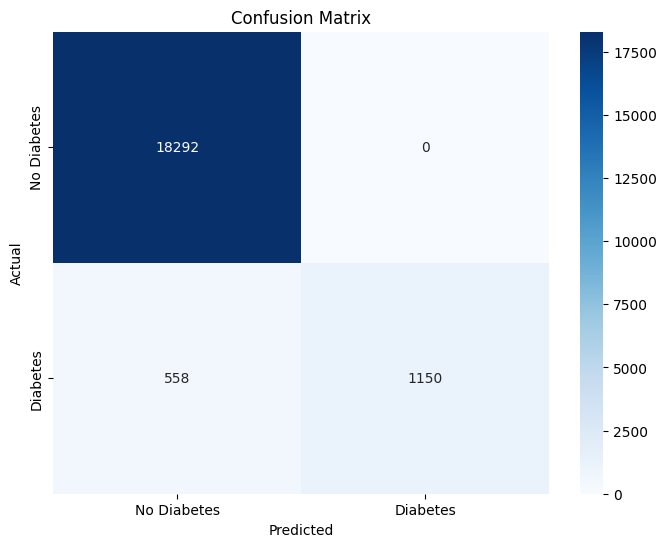

In [ ]:
#Confusion Matrix heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace 'y_test' and 'ensemble_predictions' with your actual test labels and predictions
cm = confusion_matrix(y_test, ensemble_predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
 # import libraries
import pandas as pd
import numpy as np

In [ ]:
#load the data into a dataframe
data = pd.read_csv('/content/drive/MyDrive/dia.csv')
#check the first 5 rows
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
data = data.replace('Female',0)
data = data.replace('Male',1)
data = data.replace('never',0)
data = data.replace('No Info',1)
data = data.replace('current',0)
data = data.replace('not current',1)
data = data.replace('ever',0)
data = data.replace('former',0)
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,0,23.45,5.0,155,0
4,1,76.0,1,1,0,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
5494,1,70.0,1,0,1,34.70,6.5,155,1
5495,0,67.0,0,0,1,32.77,5.8,130,0
5496,0,39.0,0,0,0,25.67,4.5,85,0
5497,1,65.0,1,0,1,27.32,4.8,160,0


In [ ]:
y=data['diabetes']
x=data.drop('diabetes',axis=1)
x = np.array(x)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=100)

In [ ]:
from sklearn.svm import SVC
svm = SVC(probability=True)
svm.fit(xtrain,ytrain)

SVC(probability=True)

In [ ]:
from sklearn.metrics import accuracy_score
predictions = svm.predict(xtest)
svm_acc = accuracy_score(ytest, predictions)
print("Accuracy svm : ",svm_acc)

Accuracy svm :  0.9381818181818182


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(xtrain, ytrain)

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(xtrain, ytrain)

In [ ]:
predictions = clf.predict(xtest)
clf_acc = accuracy_score(ytest,predictions)
print("Accuracy MLP Classifier : ", clf_acc)

Accuracy MLP Classifier :  0.9554545454545454


In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(ytest,predictions)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[985  19]
 [ 30  66]]


In [ ]:
def calculate_metrics(tp, fp, tn, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

# Example usage
tp = 985
fp = 19
tn = 66
fn = 30

precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.9810756972111554
Recall: 0.9704433497536946
F1 Score: 0.9757305596830115


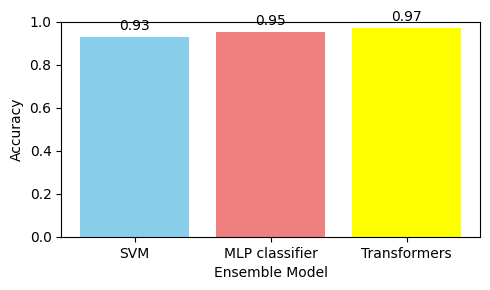

In [ ]:
import matplotlib.pyplot as plt

# Define model/experiment names and their corresponding accuracy scores
models = ['SVM', 'MLP classifier','Transformers']
accuracies = [0.93,0.95,0.97]

# Define colors for the bars
colors = ['skyblue', 'lightcoral','yellow']

# Create a bar chart with custom colors
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
bars = plt.bar(models, accuracies, color=colors)
plt.xlabel('Ensemble Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit (0 to 1 for accuracy)

# Display the accuracy scores on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, accuracy + 0.02, f'{accuracy:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

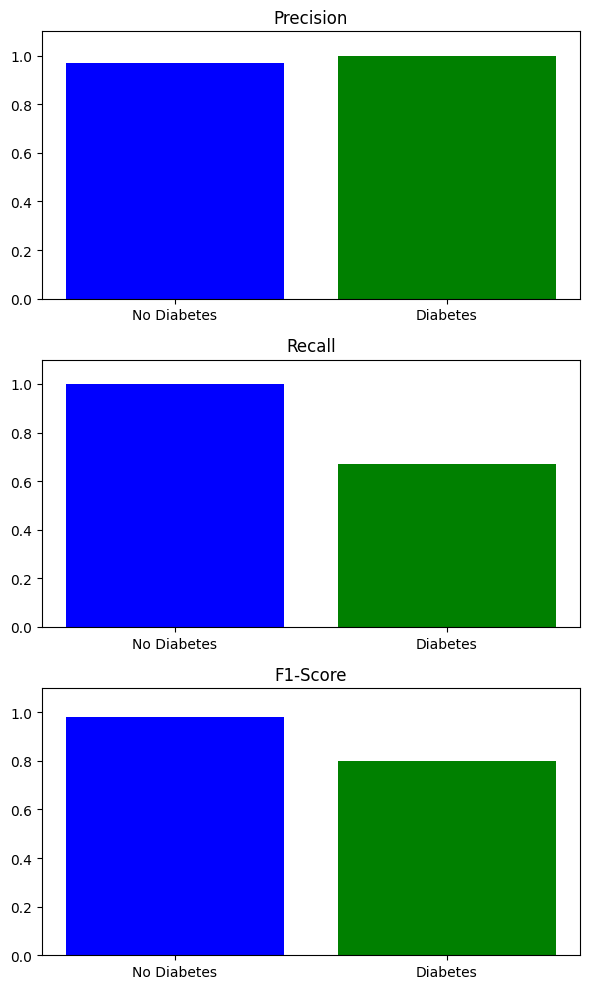

In [ ]:
import matplotlib.pyplot as plt

# Define the class names and corresponding metrics
class_names = ["No Diabetes", "Diabetes"]
precision = [0.97, 1.00]
recall = [1.00, 0.67]
f1_score = [0.98, 0.80]

# Create subplots for precision, recall, and F1-score
fig, axes = plt.subplots(3, 1, figsize=(6, 10))

# Precision plot
axes[0].bar(class_names, precision, color=['blue', 'green'])
axes[0].set_title('Precision')
axes[0].set_ylim(0.0, 1.1)

# Recall plot
axes[1].bar(class_names, recall, color=['blue', 'green'])
axes[1].set_title('Recall')
axes[1].set_ylim(0.0, 1.1)

# F1-score plot
axes[2].bar(class_names, f1_score, color=['blue', 'green'])
axes[2].set_title('F1-Score')
axes[2].set_ylim(0.0, 1.1)

# Adjust space between subplots
plt.tight_layout()

# Show the plots
plt.show()


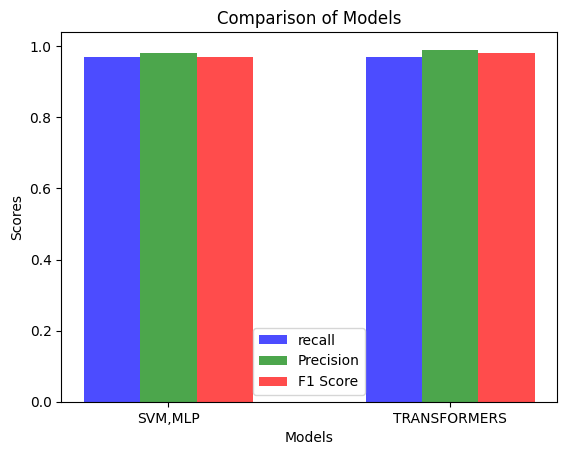

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example results for three models
model_names = ["SVM,MLP", "TRANSFORMERS"]
recall = [0.97, 0.97]
precisions = [0.98, 0.99]
f1_scores = [0.97, 0.98]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
index = np.arange(len(model_names))

# Create grouped bar chart
plt.bar(index, recall, bar_width, label='recall', color='b', alpha=0.7)
plt.bar(index + bar_width, precisions, bar_width, label='Precision', color='g', alpha=0.7)
plt.bar(index + 2*bar_width, f1_scores, bar_width, label='F1 Score', color='r', alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Models')
plt.xticks(index + bar_width, model_names)
plt.legend()

# Show the plot
plt.show()